## PU learning

In [2]:
from scipy import signal
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd

In [3]:
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import metrics

### Data Creating

Let's create some syntetic data based on gaussian windows.

[[ 9.80251676 11.70969263]
 [12.29134693 12.3507567 ]
 [ 8.21039786 10.4924401 ]
 ...
 [13.18677219 11.29525075]
 [ 8.31123336 13.54654691]
 [ 8.26707961 13.90335637]]


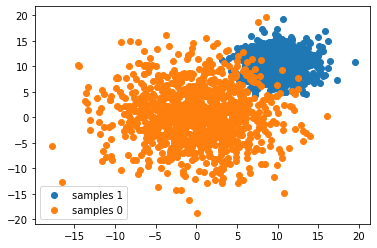

In [45]:
x = np.linspace(0, 1, 2, endpoint=False)
gaussian_arr1 = stats.multivariate_normal(x, 5, 30).rvs(1000) + np.array([10,10])
print(gaussian_arr1)
plt.scatter(gaussian_arr1[:,0], gaussian_arr1[:,1], label="samples 1")

gaussian_arr0 = stats.multivariate_normal(x, 30, 2).rvs(1000)
plt.scatter(gaussian_arr0[:,0], gaussian_arr0[:,1], label="samples 0")
plt.legend()
plt.show()

Mixing the datas to dataframe with correct labels

In [49]:
x_col = ["x" + str(i) for i in range(len(gaussian_arr0[0]))]
df = pd.DataFrame(data=np.vstack((gaussian_arr1, gaussian_arr0)), columns=x_col)
df["y"] =  [1]*len(gaussian_arr1) + [0]*len(gaussian_arr0)#1 - for gaussian 0 - for laplaccian

Suffling whole data.

In [50]:
df = df.sample(frac=1).reset_index(drop=True)

In [51]:
df.head()

,x0,x1,y
0,9.889903,12.439738,1
1,13.532338,-3.000525,0
2,0.626560,-3.795246,0
3,9.778239,12.640728,1
4,-0.379967,1.937028,0


### Normal classifier, normal data example

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df[x_col], df["y"], test_size=0.33, random_state=42)

As an exaple of classifier i would use Random Forest classifier from sklearn lib, course it one of the mentioned classifiers in article and can be easily replaced with any other from sklearn with no code changes.

In [53]:
classifier = RandomForestClassifier
params = {"n_estimators":100, "max_depth":2, "random_state":0}
# calssifier = LogisticRegression
# params = {"solver":'lbfgs'}

In [54]:
CL_ex = classifier(**params)
CL_ex.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [55]:
y_pred = CL_ex.predict(X_test)
print(f"acc is {accuracy_score(y_test, y_pred):.4f}, "
      f"f1 is {f1_score(y_test, y_pred):.4f}, "
      f"roc is {roc_auc_score(y_test, y_pred):.4f}")

acc is 0.9788, f1 is 0.9789, roc is 0.9788


Let's make some of the data undefined.

In [56]:
df["s"] = df["y"] * np.random.randint(0,2,len(df))

In [57]:
df.head()

,x0,x1,y,s
0,9.889903,12.439738,1,1
1,13.532338,-3.000525,0,0
2,0.626560,-3.795246,0,0
3,9.778239,12.640728,1,1
4,-0.379967,1.937028,0,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(df[x_col], df[["s","y"]], test_size=0.33, random_state=42)

In [59]:
CL_ex = classifier(**params)
CL_ex.fit(X_train, y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Ordinary classifier works bad with undefined data - it can't learn unreal dependense (will the value be def or undef) and can't learn real dependense - undefined data mixes everething two much.

In [60]:
CL_ex.predict(X_test)
print(f"Score for s is {CL_ex.score(X_test, y_test['s']):.4f}, course unreal dependense is hard to learn")
print(f"Score for y is {CL_ex.score(X_test, y_test['y']):.4f} course real dependense is hard to learn from unreal")
expected = y_test["y"]
predicted = CL_ex.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (CL_ex, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Score for s is 0.7530, course unreal dependense is hard to learn
Score for y is 0.5045 course real dependense is hard to learn from unreal
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       331
           1       1.00      0.01      0.01       329

    accuracy                           0.50       660
   macro avg       0.75      0.50      0.34       660
weighted avg       0.75      0.50      0.34       660


Confusion 

Let's build classifier, that would cope with defined-undefined data.

### Divide data

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df[x_col], df[["s", 'y']], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

### Fit g classificator

In [62]:
CL_g = classifier(**params)
CL_g.fit(X_train, y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Estimating c

As written in article c is probability that if data is type 1 - it will be defined data that can be estimated via classifier g, builded on Def/Undef data

There are three ways to estimate c, described in article.

In [63]:
X_val_p = X_val.loc[X_val.index[y_val["s"] == 1]]
d_p = CL_g.predict_proba(X_val_p)[:,1]
e1 = d_p.sum()/len(X_val_p)
e1

0.44215551308463236

In [64]:
d_v = CL_g.predict_proba(X_val)[:,1]
e2 = d_p.sum()/d_v.sum()
e2

0.5171054217467714

In [65]:
e3 = d_v.max()
e3

0.5037896682402127

### First way to create f classificator

###### IT IS NOT THE PART OF ARTICLE
While i was reading article, i had an idea that classifier could be easily improved with deviding result on c.

In [66]:
CL_f = classifier(**params)
CL_f.fit(X_train, y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [68]:
c = e1 # e2 or e3
y_pred = np.array(CL_f.predict_proba(X_test)[:,1]/c > 0.5, dtype=int)
accuracy_score(y_test["y"],y_pred)

0.9787878787878788

### Second way to improve classifier f

The way, that was used by the authors of article is to create weights of each sample build on g prediction for value and parametr c.

In [69]:
def create_new_train(e, X_train, y_train, CL):
    X_train_new = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 1]])
    X_train_new["w"] = 1
    y_train_new = pd.DataFrame([1]*len(X_train_new), columns=["s"])
    X_train_1 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_1[x_col])[:,1]
    X_train_1["w"] = (1-e)/e * g_x/(1-g_x)
    y_train_1 = pd.DataFrame([1]*len(X_train_1), columns=["s"])
    X_train_2 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_2[x_col])[:,1]
    X_train_2["w"] = 1 - (1-e)/e * g_x/ (1-g_x)
    y_train_2 = pd.DataFrame([0]*len(X_train_2), columns=["s"])
    X_train_new = X_train_new.append(X_train_1, ignore_index=True, sort=False)
    X_train_new = X_train_new.append(X_train_2, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_1, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_2, ignore_index=True, sort=False)
    return X_train_new, y_train_new

#### e1

In [70]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e1, X_train, y_train, CL_g)
CL_f.fit(X_train_new[x_col], y_train_new["s"], sample_weight=X_train_new['w'])
y_pred = CL_f.predict(X_test)
expected = y_test["y"]
predicted = CL_f.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (CL_f, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       331
           1       0.97      0.99      0.98       329

    accuracy                           0.98       660
   macro avg       0.98      0.98      0.98       660
weighted avg       0.98      0.98      0.98       660


Confusion matrix:
[[321  10]
 [  4 325]]


#### e2

In [71]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e2, X_train, y_train, CL_g)
CL_f.fit(X_train_new[x_col], y_train_new["s"], sample_weight=X_train_new['w'])
expected = y_test["y"]
predicted = CL_f.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (CL_f, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       331
           1       0.97      0.97      0.97       329

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660


Confusion matrix:
[[322   9]
 [  9 320]]


#### e3

In [72]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e3, X_train, y_train, CL_g)
CL_f.fit(X_train_new[x_col], y_train_new["s"], sample_weight=X_train_new['w'])
expected = y_test["y"]
predicted = CL_f.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (CL_f, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       331
           1       0.97      0.98      0.97       329

    accuracy                           0.97       660
   macro avg       0.97      0.97      0.97       660
weighted avg       0.97      0.97      0.97       660


Confusion matrix:
[[322   9]
 [  8 321]]


In [73]:
predicted

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,

,x0,x1
1860,-6.461302,5.813068
353,5.812205,8.308864
1333,10.816277,10.104235
905,1.281137,-12.959040
1289,10.884335,13.481002
1273,10.822944,9.307204
938,-2.450892,-0.485425
1731,7.055649,6.974902
65,3.686819,-6.611744
1323,-1.177529,-9.649272


It can be noticed that on suntetic data all estimation of c is nearly equal.

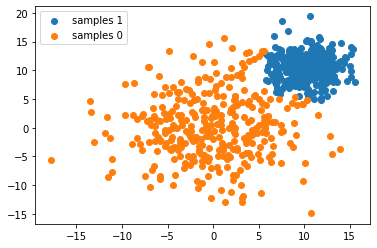

In [88]:

plt.scatter(X_test.iloc[list(np.where(predicted==1))[0]]["x0"], X_test.iloc[list(np.where(predicted==1))[0]]["x1"], label="samples 1")
plt.scatter(X_test.iloc[list(np.where(predicted==0))[0]]["x0"], X_test.iloc[list(np.where(predicted==0))[0]]["x1"], label="samples 0")
plt.legend()
plt.show()